# Processing .WAV files 

The goal of this notebook is to successfully extract numerical data from .WAV files that we can use for a classification project. 

In [3]:
# Imports 
import numpy as np 
import pandas as pd 
from scipy.io import wavfile 
import os
import librosa 

We will use wavfile and librosa to extract data from the wav file and compare. 

In [5]:
bear_file = "Animal Sounds/Bear/Bear_1.wav"
bear_dir = "Animal Sounds/Bear"
animal_dir = "Animal Sounds"
animals = ["Animal Sounds/Bear/Bear_1.wav","Animal Sounds/Cat/Cat_1.wav","Animal Sounds/Chicken/Chicken_1.wav","Animal Sounds/Lion/Lion_1.wav"]

## Extracting Features using Librosa

Some commonly used audio features for classification include:

* **MFCCs (Mel-Frequency Cepstral Coefficients)**: Captures the timbral aspects of the sound, which is crucial for distinguishing sounds with similar pitches but different characteristics
* **Spectral Features**: Describes the shape of the spectrum and provide insights into the distribution of energy across frequencies
    * **Spectral Centroid**: Associated with brightness. Sounds with high spectral centroids (e.g., cymbals) are perceived as brighter, while sounds with low centroids (e.g., bass) are darker.
    * **Spectral Bandwidth**: A high bandwidth means the sound contains a wide range of frequencies (e.g., noise), while a narrow bandwidth suggests a pure tone
    * **Spectral Rolloff**: Indicates the "tail" of the spectrum. Useful for distinguishing tonal sounds (low rolloff) from noise-like sounds (high rolloff)
    * **Zero-Crossing Rate**: Higher rates are associated with noisier or percussive sounds, while lower rates occur in harmonic or tonal sounds
* **RMS Energy**: Loudness
*  **Chroma Features**: Rate of sign changes in the waveform 

In [7]:
# Function that extracts these features from the file 

def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)  # `sr=None` retains original sample rate

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 coefficients
    mfccs_mean = np.mean(mfccs, axis=1)  # Mean of each coefficient

    # Spectral features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))

    # RMS energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Combine all features into a single vector
    features = np.hstack([
        mfccs_mean,
        spectral_centroid,
        spectral_bandwidth,
        spectral_rolloff,
        zero_crossing_rate,
        rms
    ])
    return features


In [8]:
bear_sample = extract_features(bear_file)

In [9]:
print(bear_sample)

[-4.26974449e+01  2.31592083e+01 -2.15544968e+01  2.83187675e+01
 -2.24801407e+01 -2.08504272e+00 -5.42245216e+01 -1.95991497e+01
 -1.69385281e+01 -1.93927460e+01 -2.62231503e+01 -2.08692589e+01
 -3.87858176e+00  1.45384062e+03  9.86992091e+02  2.64183728e+03
  2.45319235e-01  1.45496503e-01]


Next I'll create a function that iterates through a directory of sounds and creates a dataframe that contains all the extracted features of the audio files.

In [11]:
def process_audio_directory(directory_path):
    """
    Process all WAV files in a directory and return a DataFrame of features.
    
    Parameters:
        directory_path (str): Path to the directory containing WAV files.
    
    Returns:
        pd.DataFrame: A DataFrame containing the features of each audio file.
    """
    # Initialize an empty list to hold feature vectors
    data = []

    # Loop through all files in the directory
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.wav'):  # Process only WAV files
            file_path = os.path.join(directory_path, file_name)
            
            try:
                # Extract features
                features = extract_features(file_path)
                
                # Append to data with the file name
                data.append([file_name] + list(features))
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    
    # Define column names
    mfcc_columns = [f"mfcc_{i+1}" for i in range(13)]
    other_columns = ["spectral_centroid", "spectral_bandwidth", "spectral_rolloff", "zero_crossing_rate", "rms"]
    columns = ["file_name"] + mfcc_columns + other_columns

    # Create DataFrame
    df = pd.DataFrame(data, columns=columns)
    return df

In [12]:
def process_audio_directory_recursive(directory_path):
    """
    Process all WAV files in a directory (including nested subdirectories) 
    and return a DataFrame of features.
    
    Parameters:
        directory_path (str): Path to the root directory containing WAV files.
    
    Returns:
        pd.DataFrame: A DataFrame containing the features of each audio file.
    """
    # Initialize an empty list to hold feature vectors
    data = []

    # Walk through all files and subdirectories
    for root, _, files in os.walk(directory_path):
        for file_name in files:
            if file_name.endswith('.wav'):  # Process only WAV files
                file_path = os.path.join(root, file_name)
                
                try:
                    # Extract features
                    features = extract_features(file_path)
                    
                    # Append to data with the file name
                    data.append([file_name, file_path] + list(features))
                except Exception as e:
                    print(f"Error processing {file_name}: {e}")
    
    # Define column names
    mfcc_columns = [f"mfcc_{i+1}" for i in range(13)]
    other_columns = ["spectral_centroid", "spectral_bandwidth", "spectral_rolloff", "zero_crossing_rate", "rms"]
    columns = ["file_name", "file_path"] + mfcc_columns + other_columns

    # Create DataFrame
    df = pd.DataFrame(data, columns=columns)
    return df


In [13]:
bear_data = process_audio_directory(bear_dir)
all_data = process_audio_directory_recursive(animal_dir)
all_data

,file_name,file_path,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms
0,Cat_48.wav,Animal Sounds/Cat/Cat_48.wav,-314.806702,138.078369,41.287201,28.208643,34.031357,29.194788,13.029899,5.029216,0.453571,6.047266,6.371689,1.253936,10.816890,561.031636,1208.761502,976.406250,0.014814,0.133018
1,Cat_49.wav,Animal Sounds/Cat/Cat_49.wav,-161.108994,65.944405,-27.921473,5.517009,-1.543510,6.827643,-7.861189,9.051890,1.601618,5.718929,-1.950853,7.772140,-3.979771,1373.004053,1547.021335,2468.927557,0.037753,0.210439
2,Cat_9.wav,Animal Sounds/Cat/Cat_9.wav,-162.136154,67.970123,1.467082,8.692842,17.320860,2.949544,7.153049,5.297302,16.217827,12.687960,9.184704,-5.927985,-12.205639,2061.151130,2092.808827,4372.438525,0.147781,0.125188
3,Cat_8.wav,Animal Sounds/Cat/Cat_8.wav,-266.343048,35.188587,23.918863,17.141241,5.850997,23.924242,7.146820,8.481771,-2.085628,16.049654,6.535737,6.654588,2.575234,2582.846894,2193.742852,5333.451705,0.193271,0.029403
4,Cat_17.wav,Animal Sounds/Cat/Cat_17.wav,-139.269318,-67.046181,-47.530720,17.922523,-3.905224,14.075032,12.250045,6.449054,3.185078,3.795430,2.024894,7.970821,-5.063835,2520.633293,1137.964001,3704.010010,0.379395,0.090195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Elephant_25.wav,Animal Sounds/Elephant/Elephant_25.wav,-315.673523,20.894619,-37.539486,40.208420,-6.510990,-5.165436,5.387571,-5.869802,-7.356544,12.800898,3.845327,3.151396,2.855612,4273.021591,3057.532576,7494.654255,0.222519,0.083664
496,Elephant_19.wav,Animal Sounds/Elephant/Elephant_19.wav,-154.741104,-27.926220,-22.073019,7.826798,-15.700511,3.784553,-1.754874,10.413884,-3.058660,6.787887,6.220902,12.452734,-5.266429,2524.323375,1360.660310,4125.195782,0.417937,0.074747
497,Elephant_18.wav,Animal Sounds/Elephant/Elephant_18.wav,-358.656616,38.096474,-9.381742,28.722048,0.408628,4.316041,5.891005,3.334529,4.987509,5.735271,-4.123981,3.396932,-4.868723,3585.826001,2809.087701,6879.913330,0.224657,0.039202
498,Elephant_24.wav,Animal Sounds/Elephant/Elephant_24.wav,-161.908066,-49.868374,7.743320,-2.468374,-18.794113,16.575644,-10.305703,3.386245,-12.408296,19.790922,-6.970393,20.319040,-0.997865,3020.181167,1228.271737,4279.413546,0.519516,0.125339


Number of components selected: 9
Explained Variance Ratio: [0.22465861 0.12062838 0.09977578 0.09084111 0.07538681 0.0625712
 0.05596045 0.05278065 0.04083879]
Total variance explained: 0.82
          0         1         2         3         4         5         6  \
0 -0.095398  2.100511  1.831535 -4.038905  1.256099 -0.361520 -1.167568   
1 -0.491592  0.034466 -0.141455 -0.847009  1.294033  0.177288 -0.732773   
2  1.870779  0.405760  0.588216 -0.115162  2.173557  1.249747 -0.282770   
3  3.761074  0.654933  0.425986 -0.799421  0.337971  0.023488 -0.813760   
4  2.453293 -2.624020  0.358148 -0.585753 -0.529975 -0.181715  0.746486   

          7         8 animal_label  
0 -0.720815  0.473877          Cat  
1  0.456830  0.613661          Cat  
2 -0.012677 -0.743817          Cat  
3 -0.489427  0.227139          Cat  
4  0.144862  0.276384          Cat  


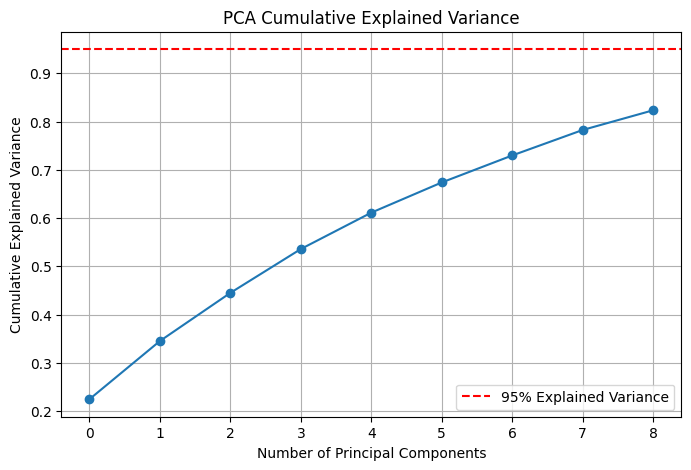

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual DataFrame)
# df = pd.read_csv("audio_features.csv")
animal_features = all_data.drop(columns=["file_name","file_path"])  # Drop non-numeric columns

# Standardize the data
scaler = StandardScaler()
animal_scaled = scaler.fit_transform(animal_features)

# Apply PCA with 95% variance retention
pca = PCA(n_components=0.80)  # Retain 95% of variance
principal_components = pca.fit_transform(animal_scaled)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=principal_components)

# Print the number of components selected
print(f"Number of components selected: {pca.n_components_}")

# Explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Total variance explained
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2f}")

# Adding back file names 
pca_df['file_name'] = all_data['file_name'].values

# Re-labeling file name to animal label 
pca_df['animal_label'] = pca_df['file_name'].str.split('_').str[0]

# Dropping file-name
pca_df = pca_df.drop(columns=["file_name"]) 

# View the first few rows of PCA-transformed data
print(pca_df.head())

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.legend(loc='best')
plt.grid()
plt.show()

Now, I will run a K-means clustering algorithm on the PCA transformed data to clasify the data. 

cluster       0   1  2   3  4   5   6   7   8   9
animal_label                                     
Bear          0   6  0   7  0  37   0   0   0   0
Cat           1   5  7   3  0   3   7  11  11   2
Chicken       0   7  5   2  5   5  11   9   6   0
Cow           0  28  4  11  1   4   1   0   1   0
Dog           0   3  1  17  0   2  12  14   0   1
Dolphin       6   0  1   0  0   3   2   0  10  28
Donkey        0  26  0   1  0   4   1   2   7   9
Elephant      1   3  1   8  7   0  15   6   8   1
Frog          0  10  8   7  7   7   2   4   4   1
Lion          0  12  1  27  6   4   0   0   0   0


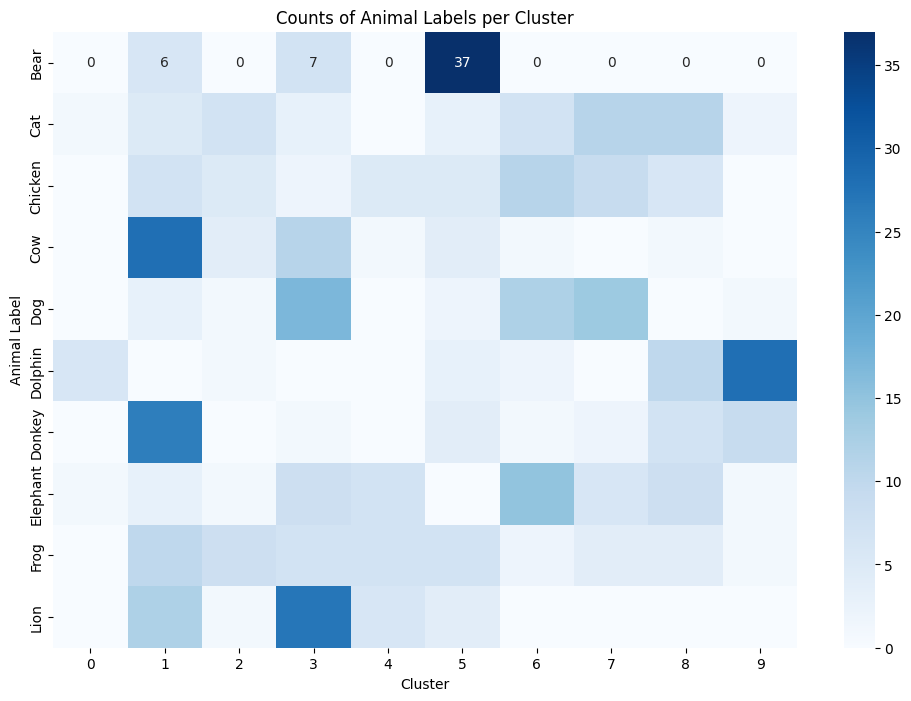

Adjusted Rand Index (ARI): 0.15
Normalized Mutual Information (NMI): 0.28
Homogeneity Score: 0.27
Completeness Score: 0.29
V-Measure Score: 0.28


In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from scipy.optimize import linear_sum_assignment
import seaborn as sns

# Step 1: Run K-means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(principal_components)

# Step 2: Create a contingency matrix
contingency_matrix_k_means = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Step 3: Ensure all clusters and labels are represented
# Reindex the contingency matrix to include all expected clusters and labels
expected_clusters = range(kmeans.n_clusters)
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_k_means = contingency_matrix_k_means.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)

# Printing Contingency Matrix 
print(contingency_matrix_k_means)

# Step 4: Visualize the contingency matrix
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_matrix_k_means, annot=True, fmt='d', cmap='Blues', xticklabels=expected_clusters, yticklabels=expected_labels)
plt.xlabel('Cluster')
plt.ylabel('Animal Label')
plt.title('Counts of Animal Labels per Cluster')
plt.show()

# Step 5: Clustering performance metrics

# ARI: Adjusted Rand Index
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# NMI: Normalized Mutual Information
nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

# Homogeneity Score
homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Homogeneity Score: {homogeneity:.2f}")

# Completeness Score
completeness = completeness_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Completeness Score: {completeness:.2f}")

# V-Measure Score
v_measure = v_measure_score(pca_df['animal_label'], pca_df['cluster'])
print(f"V-Measure Score: {v_measure:.2f}")

Now, we'll compare with a Spectral Clustering algorithm 

cluster        0   1  2   3   4   5   6   7   8
animal_label                                   
Bear           8   0  0   4   0   0   0   0   2
Cat            0  16  0  21   0   1   0   6   2
Chicken        0  19  5  21   0   1   0   2   1
Cow           11   5  1  16   0   0   0  14   0
Dog            0   0  0  31   1  13   0   1   2
Dolphin        0  12  0   3  28   0   0   0   0
Donkey         0   9  0   8   9   0   0  23   0
Elephant       0  15  6  23   1   1   0   1   2
Frog           1   3  8  11   1   0  12   4   5
Lion           4   0  5  19   0   0   0   4  15


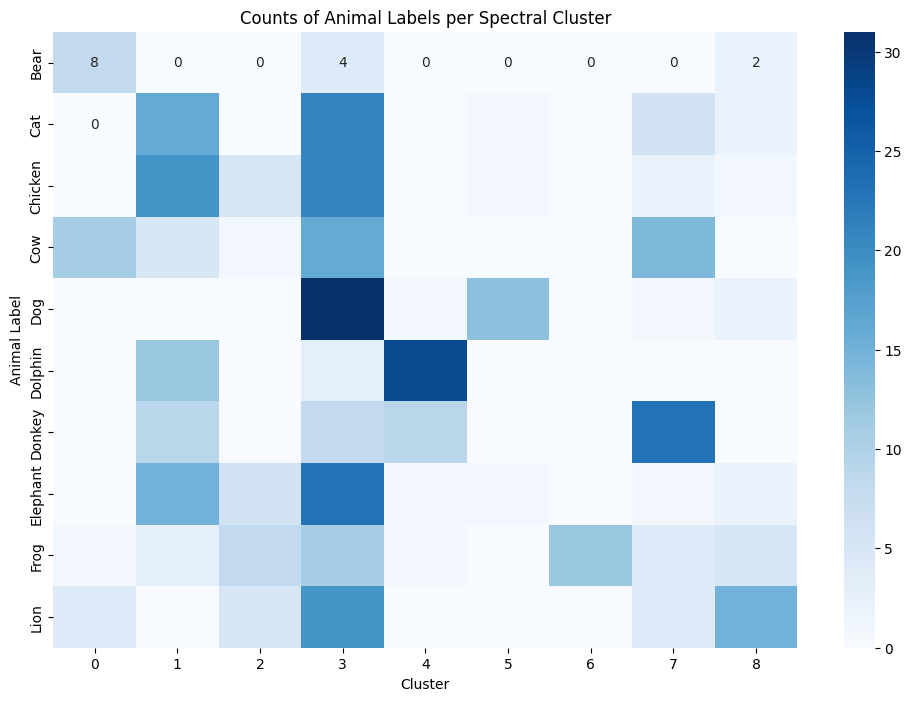

Adjusted Rand Index (ARI): 0.13
Normalized Mutual Information (NMI): 0.31
Homogeneity Score: 0.29
Completeness Score: 0.33
V-Measure Score: 0.31


In [18]:
from sklearn.cluster import SpectralClustering

# Step 1: Run Spectral Clustering
spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=42)
pca_df['cluster'] = spectral.fit_predict(principal_components)

# Step 2: Create a contingency matrix
contingency_matrix_spectral = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Step 3: Ensure all clusters and labels are represented
# Reindex the contingency matrix to include all expected clusters and labels
expected_clusters = range(9)  # Adjust based on n_clusters
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_spectral = contingency_matrix_spectral.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)

# Printing contingency table 
print(contingency_matrix_spectral)

# Step 4: Visualize the contingency matrix
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_matrix_spectral, annot=True, fmt='d', cmap='Blues', xticklabels=expected_clusters, yticklabels=expected_labels)
plt.xlabel('Cluster')
plt.ylabel('Animal Label')
plt.title('Counts of Animal Labels per Spectral Cluster')
plt.show()

# Step 5: Clustering performance metrics

# ARI: Adjusted Rand Index
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# NMI: Normalized Mutual Information
nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

# Homogeneity Score
homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Homogeneity Score: {homogeneity:.2f}")

# Completeness Score
completeness = completeness_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Completeness Score: {completeness:.2f}")

# V-Measure Score
v_measure = v_measure_score(pca_df['animal_label'], pca_df['cluster'])
print(f"V-Measure Score: {v_measure:.2f}")

Now we'll use a GMM to compare performance

cluster       0   1  2   3  4   5   6   7   8
animal_label                                 
Bear          0   2  0   7  0  38   2   1   0
Cat           1   0  6   2  5   1   8  19   8
Chicken       0   0  4   1  5   4   9  20   7
Cow           0   6  1   8  1   8   6  15   5
Dog           0   0  0  12  0   1  12  24   0
Dolphin       6   0  1   0  0   2   0   3  11
Donkey        0  22  0   0  2   4   1   2   9
Elephant      1   0  1   7  8   0  13  14   5
Frog          0  12  8   7  9   1   3   5   3
Lion          0   3  1  28  8   3   7   0   0


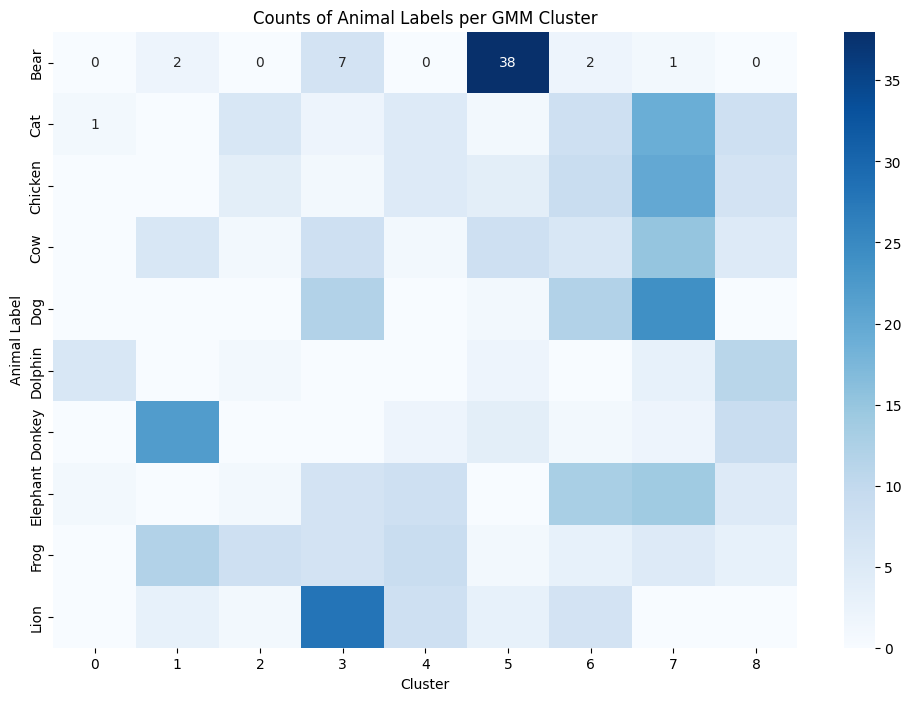

Adjusted Rand Index (ARI): 0.16
Normalized Mutual Information (NMI): 0.29
Homogeneity Score: 0.28
Completeness Score: 0.30
V-Measure Score: 0.29


In [20]:
from sklearn.mixture import GaussianMixture

# Step 1: Run Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)
pca_df['cluster'] = gmm.fit_predict(principal_components)

# Step 2: Create a contingency matrix
contingency_matrix_gmm = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Step 3: Ensure all clusters and labels are represented
# Reindex the contingency matrix to include all expected clusters and labels
expected_clusters = range(9)  # Adjust based on n_components
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_gmm = contingency_matrix_gmm.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)

# Printing contingecny matrix
print(contingency_matrix_gmm)

# Step 4: Visualize the contingency matrix
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_matrix_gmm, annot=True, fmt='d', cmap='Blues', xticklabels=expected_clusters, yticklabels=expected_labels)
plt.xlabel('Cluster')
plt.ylabel('Animal Label')
plt.title('Counts of Animal Labels per GMM Cluster')
plt.show()

# Step 5: Clustering performance metrics

# ARI: Adjusted Rand Index
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# NMI: Normalized Mutual Information
nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

# Homogeneity Score
homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Homogeneity Score: {homogeneity:.2f}")

# Completeness Score
completeness = completeness_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Completeness Score: {completeness:.2f}")

# V-Measure Score
v_measure = v_measure_score(pca_df['animal_label'], pca_df['cluster'])
print(f"V-Measure Score: {v_measure:.2f}")

Now we'll do a self organizing map

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.3133871840924831


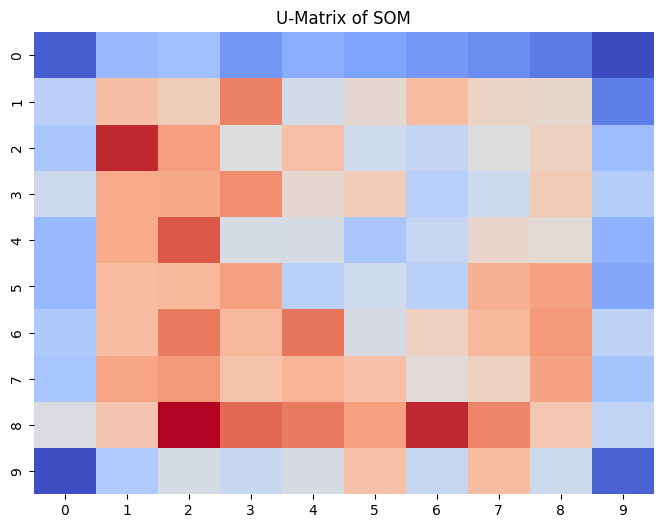

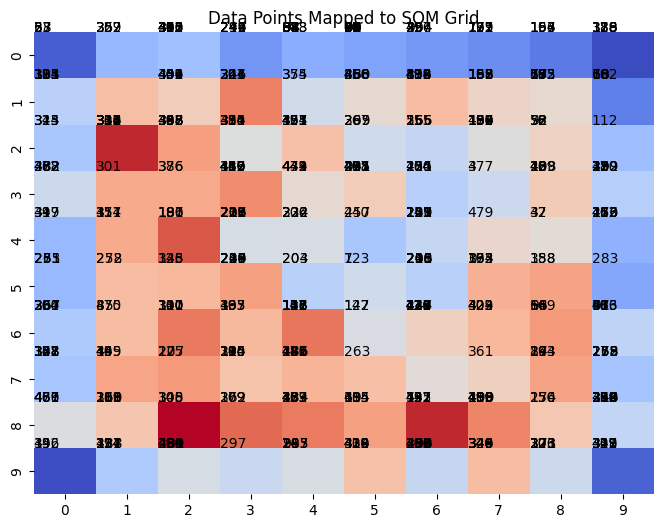

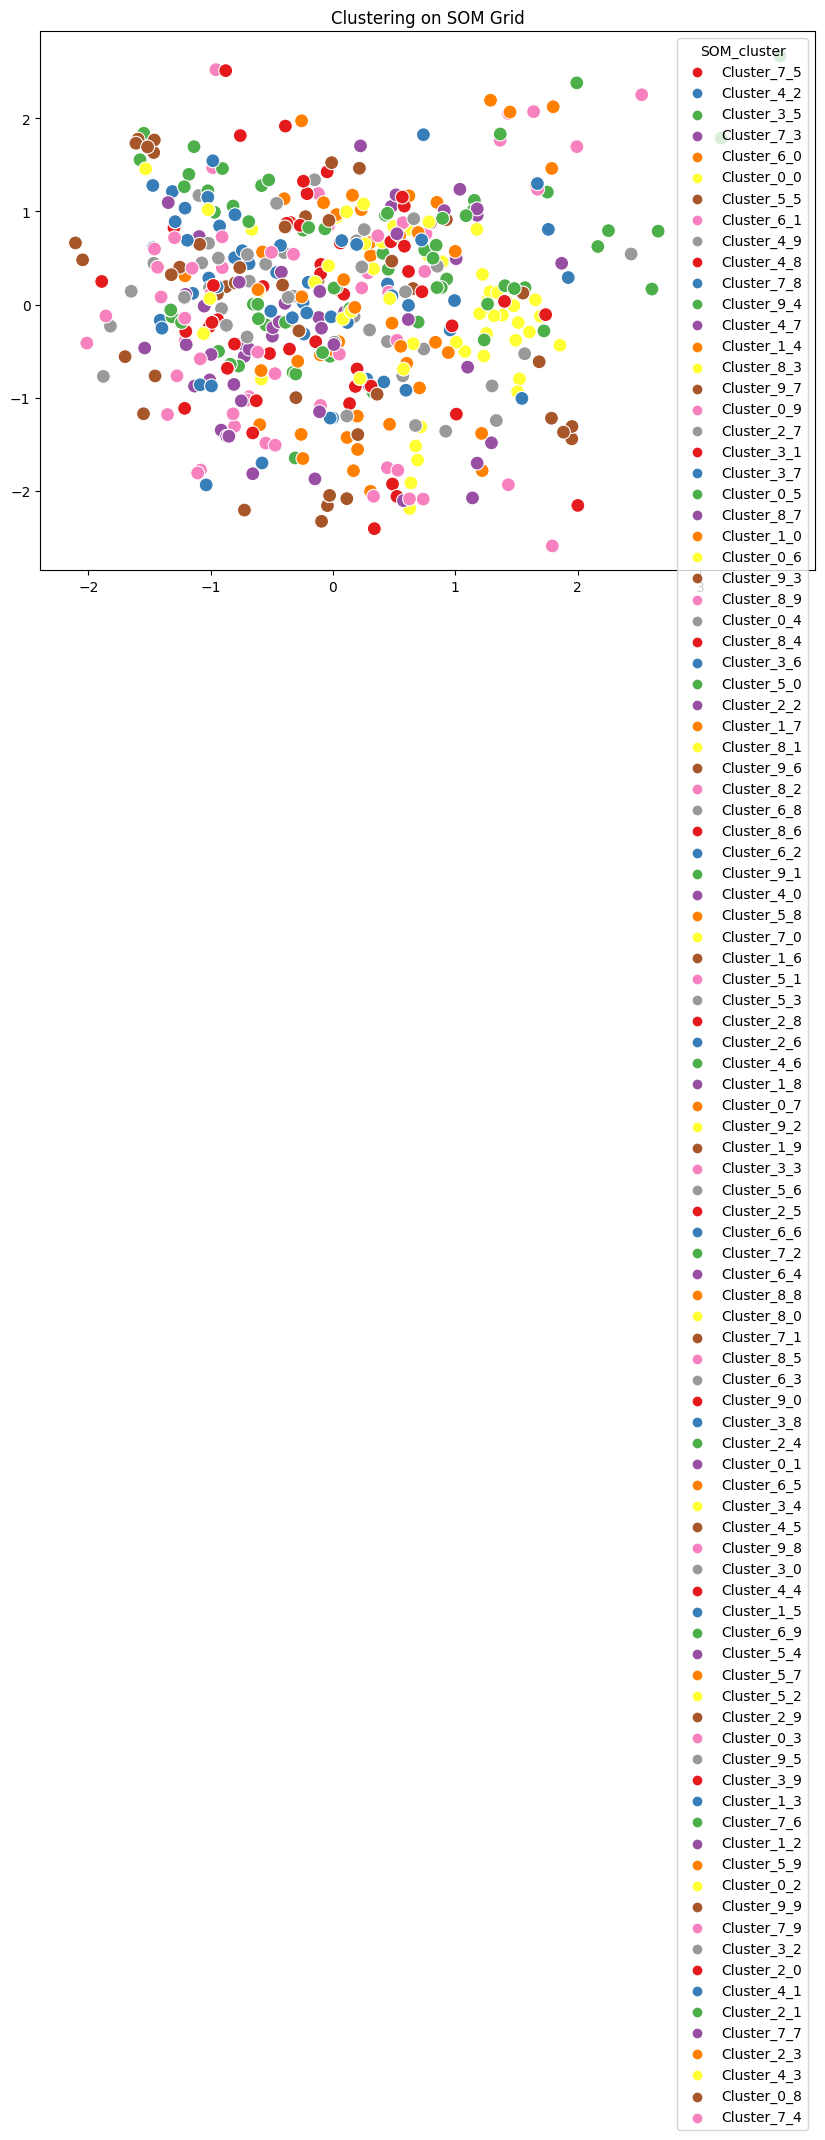

Adjusted Rand Index (ARI): 0.09
Normalized Mutual Information (NMI): 0.47
Homogeneity: 0.69
Completeness: 0.36
V-Measure: 0.47


In [22]:
from minisom import MiniSom

# Step 1: Standardize the data (if not already done)
scaler = StandardScaler()
animal_scaled = scaler.fit_transform(principal_components)  # Assuming 'principal_components' is your data

# Step 2: Initialize the SOM
som = MiniSom(x=10, y=10, input_len=animal_scaled.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)

# Step 3: Train the SOM
som.train(animal_scaled, 1000, verbose=True)

# Step 4: Plot the SOM's U-matrix
# U-matrix visualizes the distance between the neurons in the SOM grid. Larger distances mean dissimilarity.
plt.figure(figsize=(8, 6))
plt.title("U-Matrix of SOM")
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)
plt.show()

# Step 5: Plot the data points on the SOM grid
plt.figure(figsize=(8, 6))
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)

# Assign each data point to a neuron (winning node)
win_map = som.win_map(animal_scaled)

# We can use the same colors to show where the data points map on the SOM grid
for label in range(len(animal_scaled)):
    x, y = som.winner(animal_scaled[label])
    plt.text(x, y, str(label), color='black', fontsize=10)

plt.title('Data Points Mapped to SOM Grid')
plt.show()

# Step 6: Visualize the SOM clusters
# Cluster the data points by grouping based on their winning node
# You can assign each point a cluster label (i.e., the coordinates of the winning node)
labels_som = np.array([som.winner(x) for x in animal_scaled])

# Convert coordinates to cluster labels
cluster_labels = np.array([f'Cluster_{x[0]}_{x[1]}' for x in labels_som])

# Add the cluster labels to your dataframe
pca_df['SOM_cluster'] = cluster_labels

# Step 7: Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=animal_scaled[:, 0], y=animal_scaled[:, 1], hue=pca_df['SOM_cluster'], palette='Set1', s=100)
plt.title("Clustering on SOM Grid")
plt.show()

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

# Homogeneity
homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Homogeneity: {homogeneity:.2f}")

# Completeness
completeness = completeness_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Completeness: {completeness:.2f}")

# V-Measure
v_measure = v_measure_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"V-Measure: {v_measure:.2f}")



## Processing the File using a Spectrogram 

Another option for extracting components is to represent the audio as a Spectrogram and performing a PCA on the image to extract the components. 

In [24]:
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
def plot_spectrograms_grid(audio_files, rows, cols, figsize=(15, 10), cmap='viridis'):
    """
    Generates and plots spectrograms for multiple audio files in a grid layout.
    
    Parameters:
        audio_files (list): List of paths to audio files.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the overall figure (default: (15, 10)).
        cmap (str): Color map for the spectrograms (default: 'viridis').
    """
    if rows * cols < len(audio_files):
        raise ValueError("Grid size (rows * cols) is smaller than the number of audio files.")
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array to simplify indexing

    for i, audio_file in enumerate(audio_files):
        # Load the audio file
        y, sr = librosa.load(audio_file)

        # Compute the spectrogram in dB
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

        # Plot the spectrogram
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap=cmap, ax=axes[i])
        axes[i].set_title(f'Spectrogram: {audio_file}')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Frequency (Hz)')

    # Hide unused subplots
    for j in range(len(audio_files), len(axes)):
        axes[j].axis('off')

    # Add a shared colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes, format='%+2.0f dB', orientation='vertical', fraction=0.02, pad=0.04)
    plt.show()

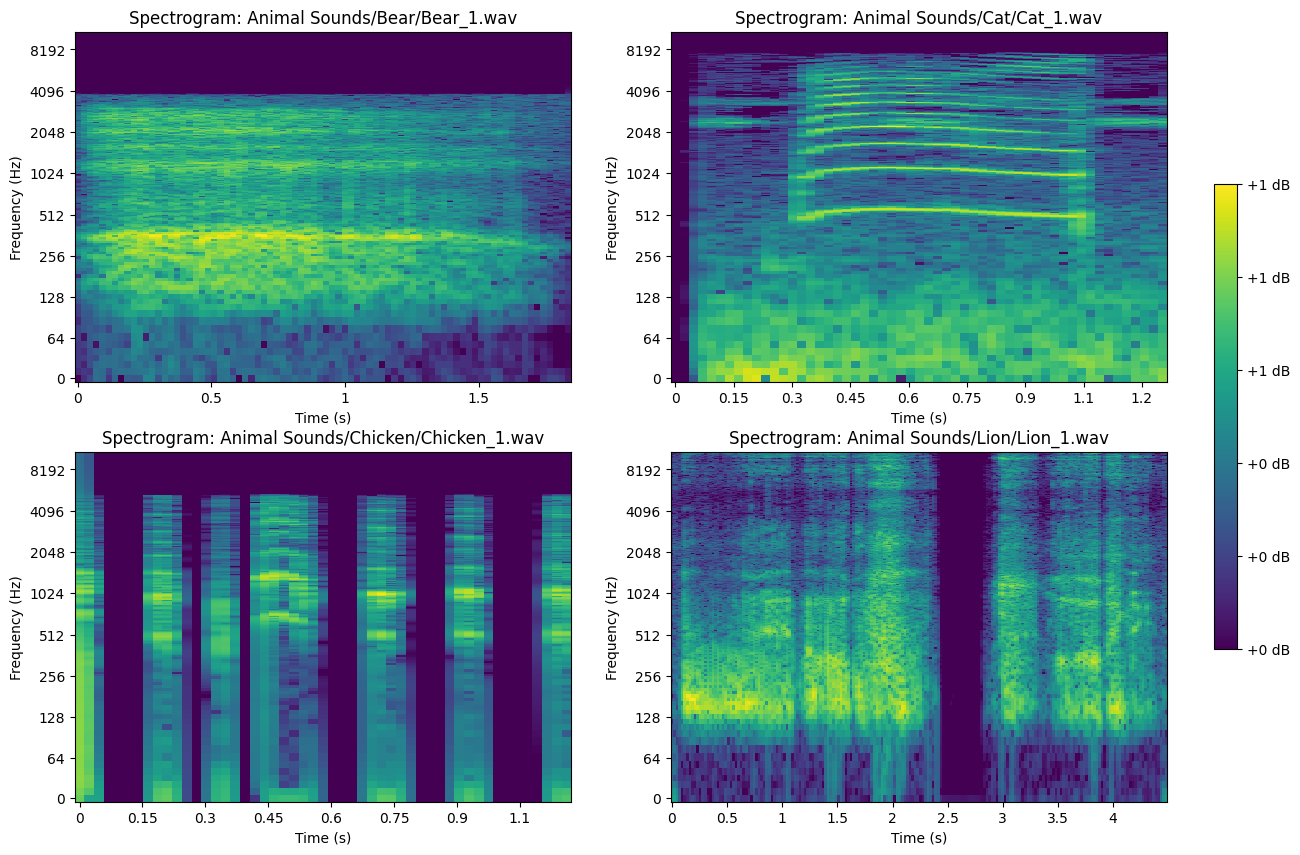

In [25]:
plot_spectrograms_grid(animals,rows=2,cols=2)

Now, I'll transform all the data into Spectrograms and represent the data in a matrix of image data. 

In [27]:
def process_wav_directory_to_spectrogram_df(root_dir):
    """
    Processes all .wav files in a directory and its subdirectories, computes their spectrograms,
    and stores the data in a pandas DataFrame.

    Parameters:
        root_dir (str): Path to the root directory containing .wav files.

    Returns:
        pandas.DataFrame: A DataFrame containing flattened spectrogram data for each file.
                          Columns are spectrogram features, and rows are files.
    """
    data = []
    file_paths = []

    # Walk through the directory and subdirectories
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(subdir, file)
                try:
                    # Load the audio file
                    y, sr = librosa.load(file_path, sr=None)  # Use original sample rate
                    
                    # Generate the Mel spectrogram
                    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
                    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to dB scale
                    
                    # Flatten the spectrogram and store in list
                    flattened_spectrogram = S_dB.flatten()
                    data.append(flattened_spectrogram)
                    file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame(data)
    df['file_path'] = file_paths  # Add a column for file paths

    return df



In [28]:
spectrogram_data = process_wav_directory_to_spectrogram_df(animal_dir)

/opt/anaconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [29]:
spectrogram_data = spectrogram_data.fillna(0)
spectrogram_data

,0,1,2,3,4,5,6,7,8,9,...,217207,217208,217209,217210,217211,217212,217213,217214,217215,file_path
0,-37.908813,-30.276293,-29.758854,-30.850702,-32.906429,-29.509600,-27.149952,-25.388840,-24.356577,-26.545677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Animal Sounds/Cat/Cat_48.wav
1,-30.295763,-4.674400,0.000002,-1.395042,-2.048786,-2.170826,-1.794014,-1.656761,-1.244608,-1.594776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Animal Sounds/Cat/Cat_49.wav
2,-80.000000,-43.347843,-30.281017,-25.457041,-24.546291,-25.288666,-27.071245,-31.447849,-32.214695,-28.817442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Animal Sounds/Cat/Cat_9.wav
3,-13.258572,-13.333921,-21.170664,-18.260372,-16.467819,-18.740658,-16.180864,-12.403542,-13.525305,-15.038227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Animal Sounds/Cat/Cat_8.wav
4,-14.475774,-14.764833,-15.858322,-15.786572,-15.772683,-15.825964,-15.703833,-15.596918,-15.446656,-15.531482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Animal Sounds/Cat/Cat_17.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-65.666122,-61.887550,-65.445992,-66.048431,-64.354210,-60.363510,-60.778145,-63.732262,-68.873482,-70.231850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Animal Sounds/Elephant/Elephant_25.wav
496,-34.342575,-34.864094,-35.533493,-35.156723,-34.401749,-34.522659,-34.980751,-35.140446,-34.630619,-34.256359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Animal Sounds/Elephant/Elephant_19.wav
497,-58.337250,-56.282852,-61.259201,-59.985390,-58.541077,-58.647232,-57.246140,-59.505951,-56.650826,-57.556152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Animal Sounds/Elephant/Elephant_18.wav
498,-36.413704,-36.170933,-37.919476,-37.477669,-38.828011,-39.242744,-38.245037,-38.727264,-38.939529,-38.628944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Animal Sounds/Elephant/Elephant_24.wav


In [30]:
def extract_label(file_path):
    """
    Extracts the label from a file path.
    
    Assumes the label is the second folder in the file path.
    """
    # Split the path into parts based on the directory separator
    parts = os.path.normpath(file_path).split(os.sep)
    return parts[1]  # Second part contains the label

# Example Usage
file_path = 'Animal Sounds/Cat/Cat_17.wav'
label = extract_label(file_path)
print(label)  # Output: Cat


Cat


Number of components selected: 13
Explained Variance Ratio: [0.33966933 0.12205609 0.08330181 0.05677765 0.04359446 0.03270852
 0.0313088  0.02162478 0.01907852 0.01507249 0.01323001 0.01125409
 0.01083089]
Total variance explained: 0.80
             0            1            2           3            4           5  \
0   758.752515  -514.423226 -1128.468377 -655.328600 -1686.617780 -928.722801   
1  1279.057101   449.884465   -35.322814 -122.497586  -463.302228 -286.921351   
2   563.688387  -849.912021 -1278.261062 -525.306324  -802.742110 -267.329381   
3   547.296910  -818.827706 -1130.600100 -394.965467  -457.011085  -82.736442   
4  1592.393207  1082.909454   757.554453  302.084948   735.508504  460.340939   

            6           7           8           9          10          11  \
0 -839.000772 -599.881339  444.744483    0.371113   -7.317717  214.588197   
1 -305.731171 -393.631672  331.727042 -263.725927 -406.654246 -106.936421   
2  406.589281 -241.074677 -165.452319  344.4

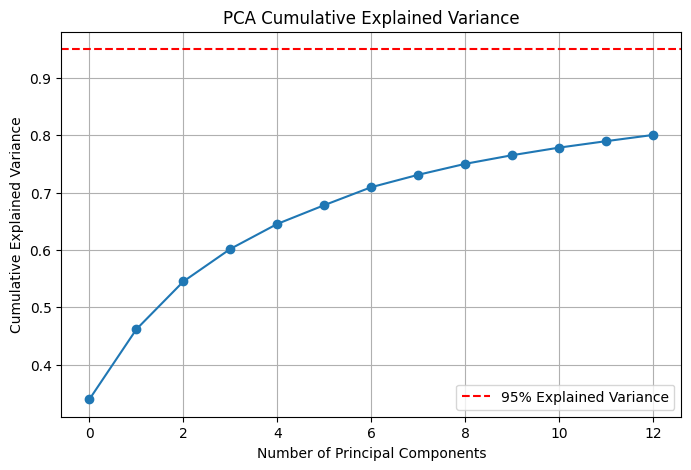

In [54]:
spectrogram_data_num = spectrogram_data.drop(columns="file_path") 

# Standardize the data
scaler = StandardScaler()
spectrogram_scaled = scaler.fit_transform(spectrogram_data_num)

# Apply PCA with 95% variance retention
pca = PCA(n_components=0.80)  # Retain 95% of variance
principal_components = pca.fit_transform(spectrogram_data_num)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=principal_components)

# Print the number of components selected
print(f"Number of components selected: {pca.n_components_}")

# Explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Total variance explained
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2f}")

# Adding back file paths 
pca_df['file_path'] = spectrogram_data['file_path'].values

# Re-labeling file name to animal label 
pca_df['animal_label'] = pca_df['file_path'].apply(extract_label)

# Dropping file-name
pca_df = pca_df.drop(columns=["file_path"]) 

# View the first few rows of PCA-transformed data
print(pca_df.head())

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.legend(loc='best')
plt.grid()
plt.show()

cluster        0  1  2   3  4  5   6   7   8  9
animal_label                                   
Bear          18  0  0  17  0  0   6   5   4  0
Cat           24  0  0   5  0  0   2  11   8  0
Chicken        5  4  1   6  1  4   1  21   6  1
Cow           13  0  0   9  0  1   7   9  11  0
Dog            7  1  0   7  0  0   2  14  19  0
Dolphin       21  1  0   9  0  0   0  15   4  0
Donkey         9  6  4  15  0  3   3   7   3  0
Elephant       6  7  2   5  0  9   7   2  12  0
Frog           6  5  6   3  0  4   2  17   6  1
Lion           3  3  6   2  0  8  12   8   5  3


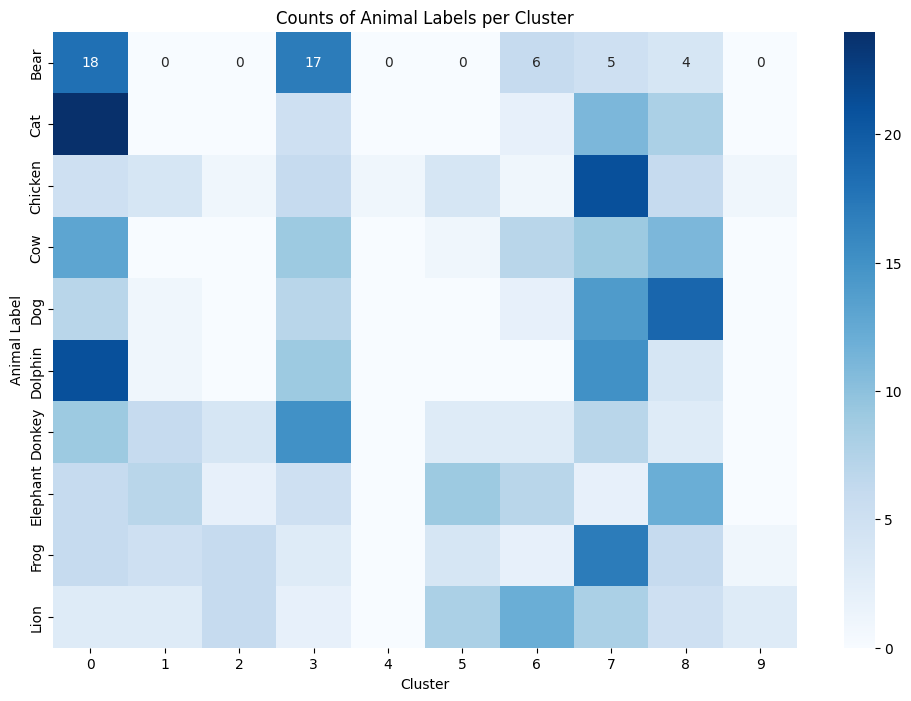

Adjusted Rand Index (ARI): 0.04
Normalized Mutual Information (NMI): 0.13
Homogeneity Score: 0.12
Completeness Score: 0.14
V-Measure Score: 0.13


In [65]:
# Step 1: Apply K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(principal_components)

# Step 2: Create a Contingency Matrix
contingency_matrix_k_means = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Step 3: Ensure all clusters and labels are represented
expected_clusters = range(kmeans.n_clusters)
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_k_means = contingency_matrix_k_means.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)

# Print Contingency Matrix
print(contingency_matrix_k_means)

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_matrix_k_means, annot=True, fmt='d', cmap='Blues', xticklabels=expected_clusters, yticklabels=expected_labels)
plt.xlabel('Cluster')
plt.ylabel('Animal Label')
plt.title('Counts of Animal Labels per Cluster')
plt.show()

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

# Homogeneity Score
homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Homogeneity Score: {homogeneity:.2f}")

# Completeness Score
completeness = completeness_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Completeness Score: {completeness:.2f}")

# V-Measure Score
v_measure = v_measure_score(pca_df['animal_label'], pca_df['cluster'])
print(f"V-Measure Score: {v_measure:.2f}")

cluster        0  1  2   3  4  5   6   7   8  9
animal_label                                   
Bear          18  0  0  16  0  0   6   5   5  0
Cat           23  0  0   6  0  0   2  11   8  0
Chicken        4  4  1   7  1  4   2  21   5  1
Cow           13  0  0   9  0  1   7   9  11  0
Dog            7  1  0   7  0  0   2  14  19  0
Dolphin       22  1  0   9  0  0   0  13   5  0
Donkey         9  6  4  15  0  3   3   7   3  0
Elephant       4  7  2   7  0  9   7   2  12  0
Frog           3  5  6   3  0  4   2  20   6  1
Lion           3  3  6   2  0  8  12   8   5  3


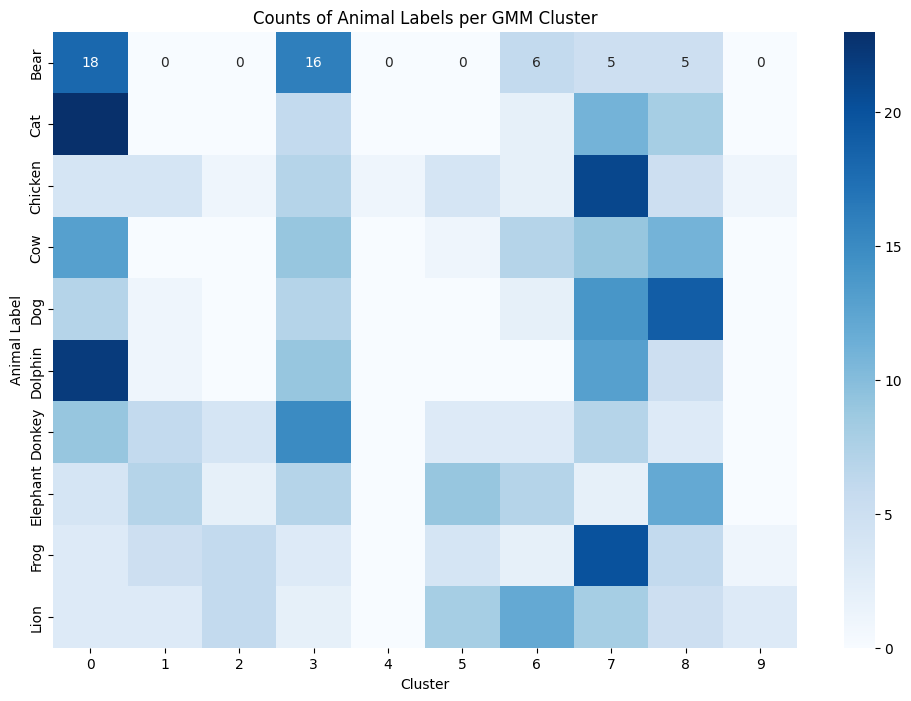

Adjusted Rand Index (ARI): 0.05
Normalized Mutual Information (NMI): 0.13
Homogeneity Score: 0.12
Completeness Score: 0.14
V-Measure Score: 0.13


In [67]:
# Step 1: Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)  # Use 10 clusters
pca_df['cluster'] = gmm.fit_predict(principal_components)

# Step 2: Create a Contingency Matrix
contingency_matrix_gmm = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Step 3: Ensure all clusters and labels are represented
expected_clusters = range(gmm.n_components)
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_gmm = contingency_matrix_gmm.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)

# Print Contingency Matrix
print(contingency_matrix_gmm)

# Step 4: Visualize the Contingency Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_matrix_gmm, annot=True, fmt='d', cmap='Blues', xticklabels=expected_clusters, yticklabels=expected_labels)
plt.xlabel('Cluster')
plt.ylabel('Animal Label')
plt.title('Counts of Animal Labels per GMM Cluster')
plt.show()

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

# Homogeneity Score
homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Homogeneity Score: {homogeneity:.2f}")

# Completeness Score
completeness = completeness_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Completeness Score: {completeness:.2f}")

# V-Measure Score
v_measure = v_measure_score(pca_df['animal_label'], pca_df['cluster'])
print(f"V-Measure Score: {v_measure:.2f}")

cluster        0   1  2   3   4   5  6   7   8   9
animal_label                                      
Bear           2  17  1   0   6   0  0   7   4  13
Cat            2  22  2   0   1   0  1   7   8   7
Chicken        7   4  9   7   0   4  6   0   6   7
Cow           12  12  4   0   4   1  0   4   6   7
Dog           13   6  4   1   1   0  6  10   5   4
Dolphin        2  18  5   1   0   0  0   5  11   8
Donkey         1   9  5   7   3   6  0   9   2   8
Elephant      14   4  1  14   4   4  0   2   1   6
Frog           5   3  4   7   2   9  9   2   7   2
Lion           6   3  4   9  10  11  0   2   4   1


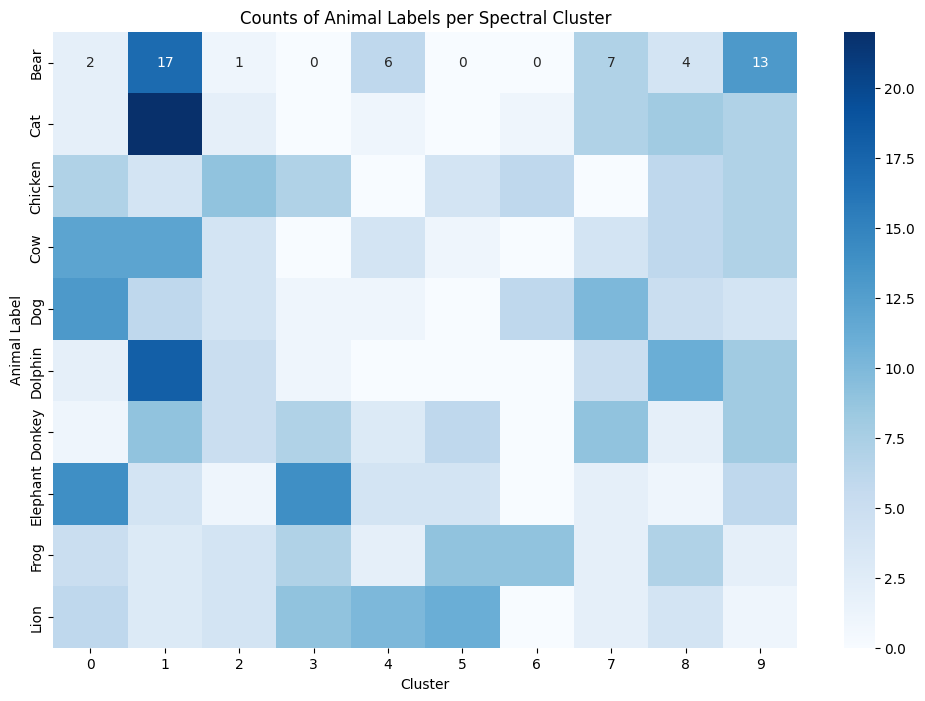

Adjusted Rand Index (ARI): 0.05
Normalized Mutual Information (NMI): 0.15
Homogeneity Score: 0.14
Completeness Score: 0.15
V-Measure Score: 0.15


In [69]:
# Step 1: Apply Spectral Clustering
spectral_clustering = SpectralClustering(
    n_clusters=10, 
    affinity='nearest_neighbors', 
    random_state=42, 
    assign_labels='kmeans'
)
pca_df['cluster'] = spectral_clustering.fit_predict(principal_components)

# Step 2: Create a Contingency Matrix
contingency_matrix_spectral = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Step 3: Ensure all clusters and labels are represented
expected_clusters = range(10)  # Number of clusters
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_spectral = contingency_matrix_spectral.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)

# Print Contingency Matrix
print(contingency_matrix_spectral)

# Step 4: Visualize the Contingency Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_matrix_spectral, annot=True, fmt='d', cmap='Blues', xticklabels=expected_clusters, yticklabels=expected_labels)
plt.xlabel('Cluster')
plt.ylabel('Animal Label')
plt.title('Counts of Animal Labels per Spectral Cluster')
plt.show()

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

# Homogeneity Score
homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Homogeneity Score: {homogeneity:.2f}")

# Completeness Score
completeness = completeness_score(pca_df['animal_label'], pca_df['cluster'])
print(f"Completeness Score: {completeness:.2f}")

# V-Measure Score
v_measure = v_measure_score(pca_df['animal_label'], pca_df['cluster'])
print(f"V-Measure Score: {v_measure:.2f}")